<h1>Statistical Analysis of NBA Players </h1>  

By: Abhimanyu Agarwala

<h3> Abstract</h3>  

In this project we are analysis different stats of an NBA player to find which stats are the most important features that go towards prediction of number of points they can score in a game. We will use methods like t-test,z-test for checking if the data are having the same mean or not. Then we will be doing Anova and Chi square for both numerial analysis and categorical analysis. Finally use linear regression with differetn feature selection Technique to find the most effective way of predicting.

<h3>Chapter 1: Introduction</h3>  

Our Data set contains 29 features of which 28 are independent and 1 is dependent feature. The data set is about the player stats for a game of basketball in NBA. It has features like 2p, 3p, FG, Pos etc and the dependent feature is Points(PTS). We will first check if our sample are having the same mean or not using either parametric or non parametric method. Then we will be doing some analysis on numerical columns and Categorical columns to find if the samples are from the same population or not. 

We then proceed to train a Linear model to find the $R^2$ score. We will further perform Resampling methods like Cross validation to check the improvment in $R^2$ score. We also perform feature selection methods like fisher score, forward selection, backward selection, ridge, lasso etc to find the most important features. Finaly we also do PCA analysis to check how many components can accomodate the 28 independent features.

Fianlly we will perform some analysis using higher degree polynomial regression and conclude our results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
import seaborn as se
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from scipy import stats
from scipy.stats import mannwhitneyu 
#!pip install pingouin

<h3> Chapter 2 </h3>
<h4>Pre-Processing of data</h4>
    <p>Steps:</p>
<ul>
<li> Load the NBA Data set which contains the Match statistics for 510 players and have 29 columns of players per game stats </li>
<li> After going through the Data set we first do some basic pre-processing steps.</li>
     <ul>
     <li>Removing Null Data as we only have 25 null values in rows for players so we remove all those rows completely from the data set</li>
     <li>We also removed mixed position values such as SF-SG, Pf-SF etc as only 4-5 records had those kind of positions</li>
     <li>We convert the Categorical column i.e. Position to numeric values with ['C':0, 'SG':1, 'PF':2, 'PG':3, 'SF':4] sequence</li>
     <li>There were only 510 unique player and few duplicate values so in-order to maintain the data sanity we are grouping by on th basis of players and finding mean of numerical columns and Pos is grouped on the basis of Mode</li>
     </ul>
<li>We have droped the players column as currently we don't require it for any analysis</li>
</ul>
    
    

In [2]:
def Data_Pre_Processing(df):
    df_1 = df
    df_1.dropna(subset=['Player'],inplace=True) #Dropping Data of people not having a player name. Because It not game analytics if we cant place a name on a player!
    df_1.drop((df[df['Pos'].isin(['SF-SG', 'PF-SF', 'SG-PG'])].index),inplace=True)
    df_1["Pos"] = df_1["Pos"].map({'C':0, 'SG':1, 'PF':2, 'PG':3, 'SF':4})
    df_1["Tm"] = df_1["Tm"].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)
    df_1["Tm"] = df_1["Tm"].map({'TOR':0, 'MEM':1, 'MIA':2, 'UTA':3, 'TOT':4, 'MIN':5, 'MIL':6, 'CLE':7, 'NOP':7,'ORL':8, 'NYK':9, 'POR':10, 'WAS':11, 'PHO':12, 'DET':13, 'GSW':14, 'CHO':15, 'LAL':16,'SAS':17, 'SAC':18, 'LAC':19, 'OKC':20, 'DAL':21, 'CHI':22, 'ATL':23, 'IND':24, 'DEN':25,'BRK':26, 'BOS':27, 'PHI':28, 'HOU':29})
    #df_1.drop("Tm",axis=1,inplace=True)
    dic_1 = {'Pos':"max",'Tm':'max','Age':'mean', 'G':'mean', 'GS':'mean', 'MP':'mean', 'FG':'mean', 'FGA':'mean', 'FG%':'mean', '3P':'mean',
       '3PA':'mean', '3P%':'mean', '2P':'mean', '2PA':'mean', '2P%':'mean', 'eFG%':'mean', 'FT':'mean', 'FTA':'mean', 'FT%':'mean', 'ORB':'mean',
       'DRB':'mean', 'TRB':'mean', 'AST':'mean', 'STL':'mean', 'BLK':'mean', 'TOV':'mean', 'PF':'mean', 'PTS':'mean'}
    df_agg = df_1.groupby("Player",as_index=False).agg(dic_1)
    df_agg.fillna(0, inplace=True)
    df_agg.drop("Player",axis=1,inplace=True)
    return df_agg
mapping_dict_1={'C':0, 'SG':1, 'PF':2, 'PG':3, 'SF':4}
mapping_dict= {'MEM':0, 'MIA':1, 'UTA':2, 'TOT':3, 'MIN':4, 'MIL':5, 'CLE':6, 'NOP':7,'ORL':8, 'NYK':9, 'POR':10, 'WAS':11, 'PHO':12, 'DET':13, 'GSW':14, 'CHO':15, 'LAL':16,'SAS':17, 'SAC':18, 'LAC':19, 'OKC':20, 'DAL':21, 'CHI':22, 'ATL':23, 'IND':24, 'DEN':25,'BRK':26, 'BOS':27, 'PHI':28, 'HOU':29,'TOR':30}
df = pd.read_csv("nba_data_processed.csv")
df_train = Data_Pre_Processing(df)
print(df_train["Tm"].unique().shape)
#df_train['Tm'] = df_train['Tm'].apply(lambda x: dict(map(reversed, mapping_dict.items())).get(x))

(29,)


In [3]:
df_train.head()

,Pos,Tm,Age,G,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,6,23.0,27.000000,0.0,9.700000,1.6,3.6,0.449,1.300000,...,1.000,0.100000,0.900000,1.100000,0.600000,0.200000,0.0,0.300000,1.000000,4.700000
1,1,21,22.0,8.666667,0.0,3.966667,1.0,1.7,0.660,0.366667,...,0.333,0.133333,0.733333,0.866667,0.066667,0.066667,0.0,0.066667,0.733333,2.433333
2,4,23,19.0,57.000000,11.0,20.200000,3.6,7.6,0.475,1.500000,...,0.875,0.500000,1.600000,2.100000,1.000000,0.700000,0.1,0.600000,1.200000,9.200000
3,2,25,27.0,50.000000,50.0,30.200000,6.5,11.2,0.583,1.000000,...,0.623,2.400000,4.500000,6.800000,2.900000,0.800000,0.8,1.600000,1.900000,17.100000
4,3,23,26.0,51.000000,5.0,14.300000,1.5,3.7,0.415,0.600000,...,0.857,0.400000,0.900000,1.300000,1.300000,0.500000,0.2,0.600000,1.300000,4.100000


<h3><ul><li> We know that our data is independent because they contains stats of 510 different players who stats are in no way dependent on each other so we can always take the columns to be independent.</li>

<BR>
<li>We will further do some Data Analysis and plot some relationship before going forward with the comparision of 2 samples</li></ul></h3>

Let us plot the graph to find the top 5 Team with the highest points, 3 Point Attempted and Free Throws:

In [4]:
df_top_5 = df_train.groupby("Tm",as_index=False).agg({'FT':'sum','3P':'sum','PTS':'sum'})
df_top_5_final = df_top_5.sort_values(["FT","3P","PTS"], ascending=False).reset_index().head(5) 
df_top_5_final['Tm'] = df_top_5_final['Tm'].apply(lambda x: dict(map(reversed, mapping_dict.items())).get(x))

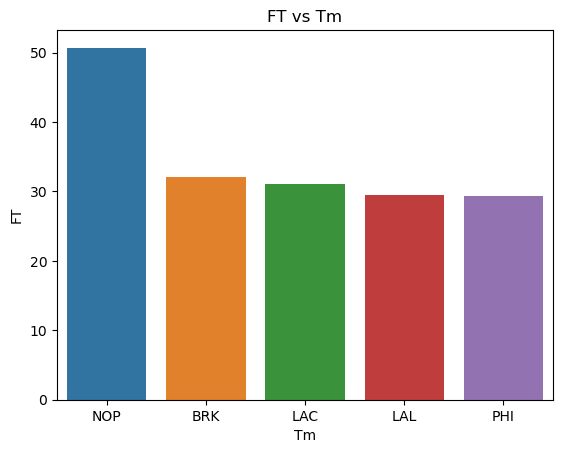

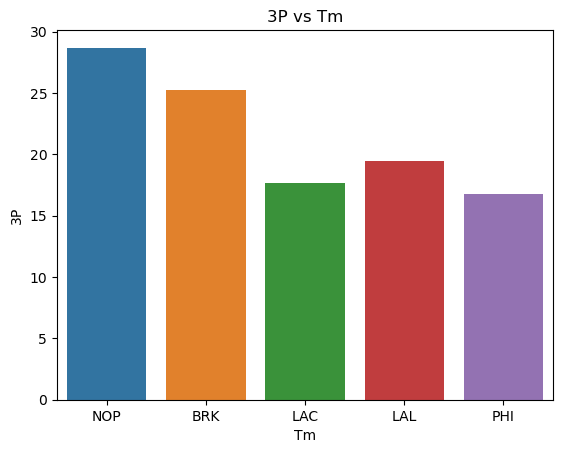

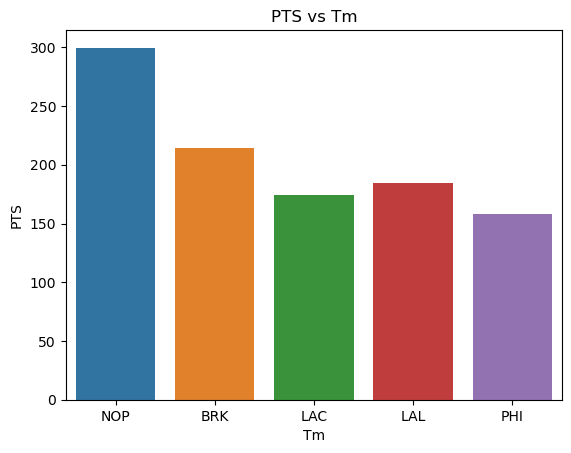

In [5]:

columns_to_plot = [col for col in df_top_5_final.columns if col not in ['Tm','index']]

# loop through each column and create a subplot
for i, col in enumerate(columns_to_plot):
    plt.figure(i)
    sns.barplot(data=df_top_5_final, x='Tm', y=col)
    plt.title(f'{col} vs Tm')
    plt.xlabel('Tm')
    plt.ylabel(col)
    plt.show()

It is clearly visible that the team which has the highest point also has the most number of 3P and Free Throws

Will perform some more Graph on later date:


Steps to perform before we start comparing two samples:
<UL>
    <li>We will plot a heatmap of the columns and see the relationship between each columns</li>
  <li> Check if all the columns are normal or not using shapiro-wilk test (Shapiro–Wilk Test, examine how close the sample data fit to a normal distribution. It does this by ordering and standardizing the sample (standardizing refers to converting the data to a distribution with mean μ=0 and standard deviation σ=1). If the sample data perfectly fit a normal distribution, then after this ordering and standardization process the sample values would be regularly spaced quantile values of the standard normal distribution)</li> 
   <li> Perform comparision on the basis of the type of distribution</li>
</UL>

In [6]:
def scaling_data(df):
    for col in df.columns:
        max_1= df[col].max()
        min_1 = df[col].min()
        df[col] = (df[col]-min_1)/(max_1-min_1)
    return df

#data_train = scaling_data(df_train.drop(columns=["Tm","Pos"]))
#data_train = scaling_data(df_train)
#data_train = data_train.join(df_train[["Tm","Pos"]])



<AxesSubplot:>

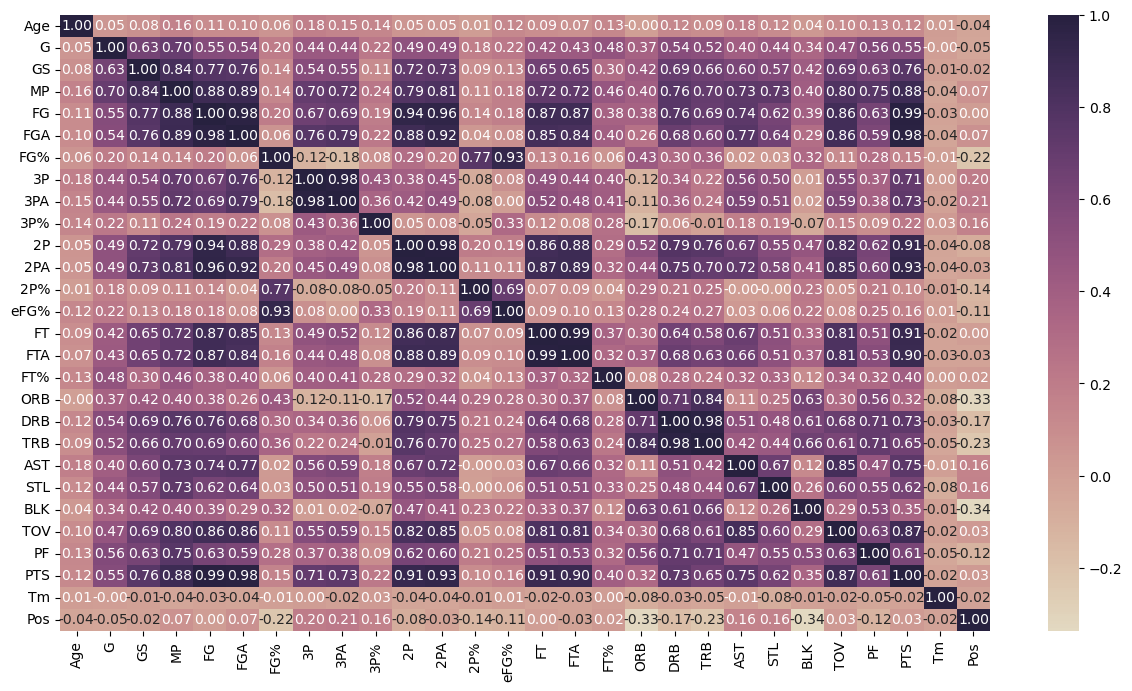

In [7]:

data_train_scale = scaling_data(df_train.drop(columns=["Tm","Pos"]))
data_train_scale_1 = data_train_scale.join(df_train[["Tm","Pos"]])
plt.figure(figsize=(15,8))
ans = data_train_scale_1.corr()
sns.heatmap(ans,annot=True,cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),fmt='.2f')

It clearly shows that FG and 2P and FT are strongly related similarly all kind of shooting is strongly related. if a person has tried more free throw attempts he also has more number of FT done and 2pt scored but it does not have a strong correlation with 3PT

Performing normal test to find out if all the columns are normal or not:
- $H_0$ = The column is normally distributed
- $H_1$ = Not Normal

In [8]:
from scipy.stats import shapiro
data_train = df_train.copy()
def hypo_test(p_value,alpha=0.05):
    if p_value<alpha:
        return("Reject H0")
    else:
        return("Accept H0 i.e. reject H1")

def Sapiro(df):
    for col in df.columns:
        test= shapiro(df[col])
        print("{}, {}".format(col,hypo_test(test.pvalue)))
Sapiro(data_train)

Pos, Reject H0
Tm, Reject H0
Age, Reject H0
G, Reject H0
GS, Reject H0
MP, Reject H0
FG, Reject H0
FGA, Reject H0
FG%, Reject H0
3P, Reject H0
3PA, Reject H0
3P%, Reject H0
2P, Reject H0
2PA, Reject H0
2P%, Reject H0
eFG%, Reject H0
FT, Reject H0
FTA, Reject H0
FT%, Reject H0
ORB, Reject H0
DRB, Reject H0
TRB, Reject H0
AST, Reject H0
STL, Reject H0
BLK, Reject H0
TOV, Reject H0
PF, Reject H0
PTS, Reject H0


In [9]:
def Hypothe(p):
    if p>0.05:
        print("Since the value of p ({}) is greater then the significance level so fail to reject {}".format(round(p,4),"H0"))
    else:
         print("We Reject H0 and the p value is {}".format(p))
            

<h3> Chapter 4</h3>

Since none of the columns are normally distributed and we have number of samples more then 30 so we will perform the Z test to check the below condition. By applying CLT.


<h3>4.1 Comparing 2 sample --> Non Parametric (z-test)</h3>

- $H_0$: Players playing center (C) scores less then or equal to Point Forward(PF)
- $H_1$: Players playing center (C) scores more then Point Forward(PF)

<br>

In [10]:
sample1 = data_train[data_train['Pos']==0].PTS
sample2 = data_train[data_train['Pos']==2].PTS
print(sample1,sample2)

8       9.4
12      0.9
15     15.0
17      6.5
22     25.7
       ... 
491     0.5
496     8.2
497    15.0
502     7.6
505    10.2
Name: PTS, Length: 97, dtype: float64 3      17.1
7       4.4
10      8.8
13      1.8
24      3.1
       ... 
495     5.7
499     6.1
503     5.4
507     5.1
509    26.0
Name: PTS, Length: 94, dtype: float64


The significance level is $\alpha = 0.05$  
<br>
Since we have a non-parametric type and have more then 30 sample so applying **z-test** by assuming normal Distribution using *Central Limit Theorum*.  

Test Statistics z: $\frac{{\bar{x_1}}-{\bar{x_2}}}{\sqrt{{\frac{{s_1}^2}{n_1}}+{\frac{{s_2}^2}{n_2}}}}$

In [11]:

sample_size = sample1.shape[0] + sample2.shape[0] - 2 

if sample_size > 30:
    #print('Sample size is:', sample_size)
    # calculate the test statistic
    sample1_var = sample1.var()
    sample2_var = sample2.var()
    z = (sample1.mean() - sample2.mean())/np.sqrt(( sample1_var/ sample1.shape[0]) + (sample2_var/sample2.shape[0]))
# calculate the p-value
p = stats.norm.cdf(-abs(z))
Hypothe(p)

Since the value of p (0.2951) is greater then the significance level so fail to reject H0


Performing same z-test using the inbuilt library statsmodels.stats.weightstats and passing the alternative i.e. $H_1$ as 'smaller'

In [12]:
# Using stats model we will compare the p values
from statsmodels.stats.weightstats import ztest as ztest


In [13]:
z_stat, p_value = ztest(sample1, sample2, value=0, alternative='smaller')

# Print the results
print('z-statistic:', z_stat)
print('p-value:', p_value)

z-statistic: -0.5395302508945554
p-value: 0.29476051470322323


Let us plot the few of columns histogram to get a better understanding of the distribution of the data.

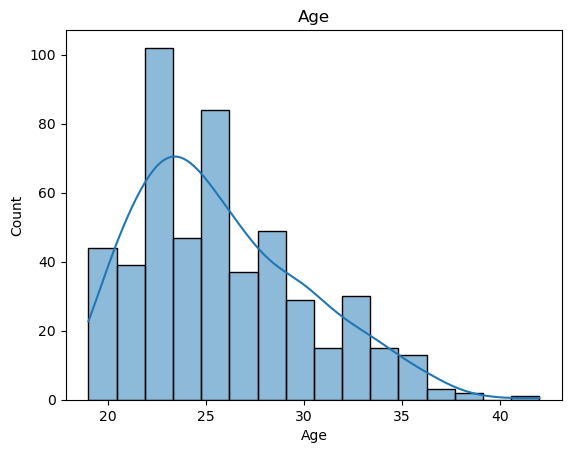

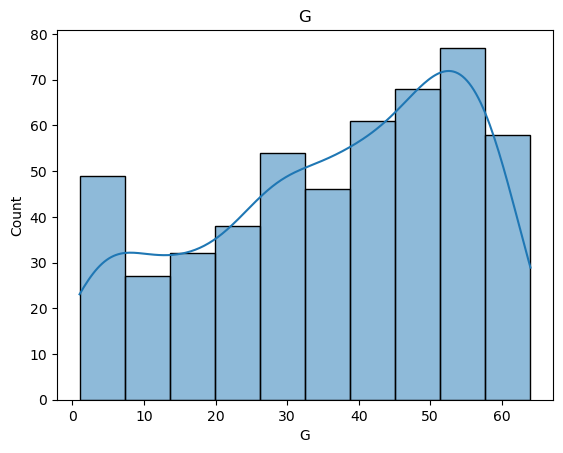

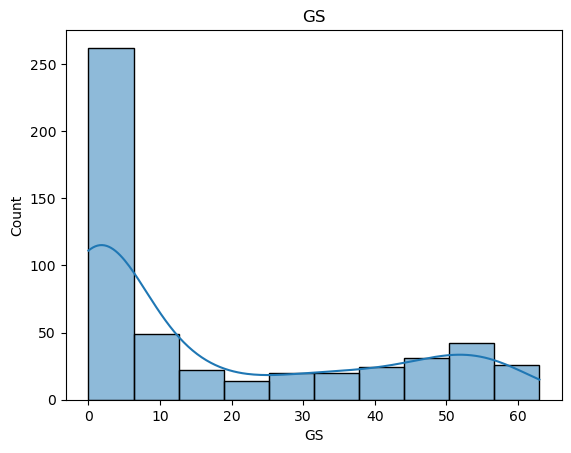

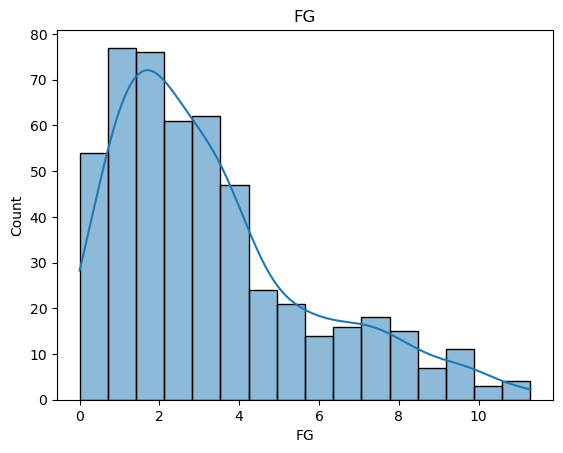

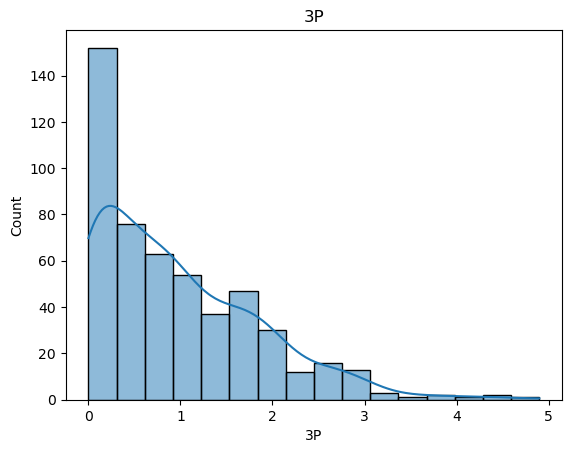

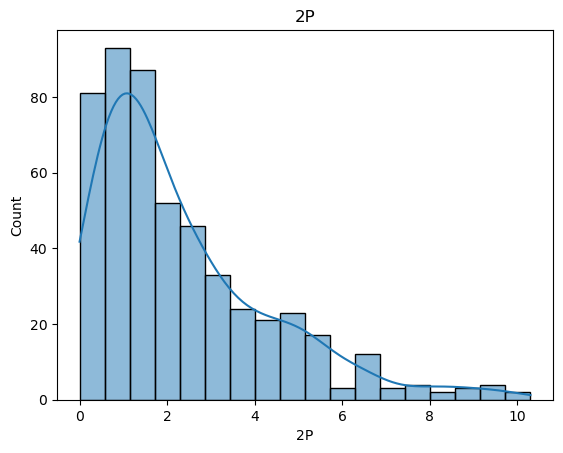

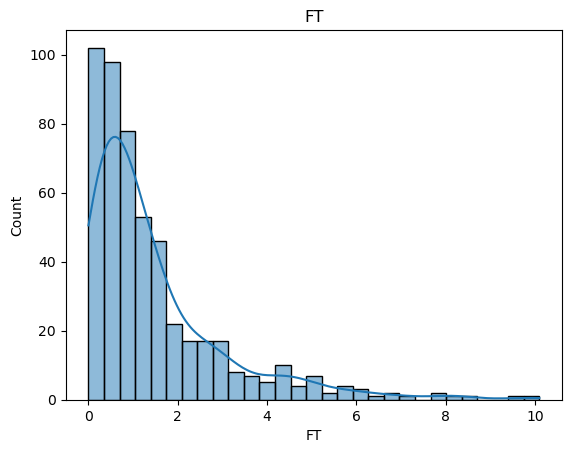

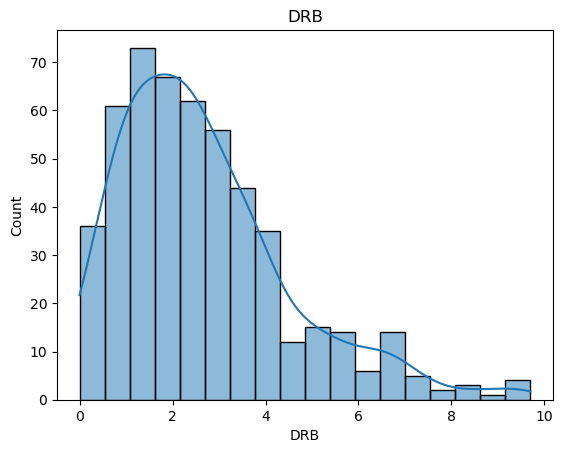

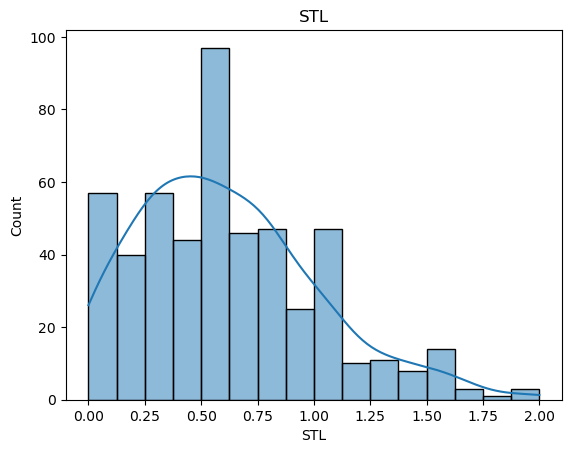

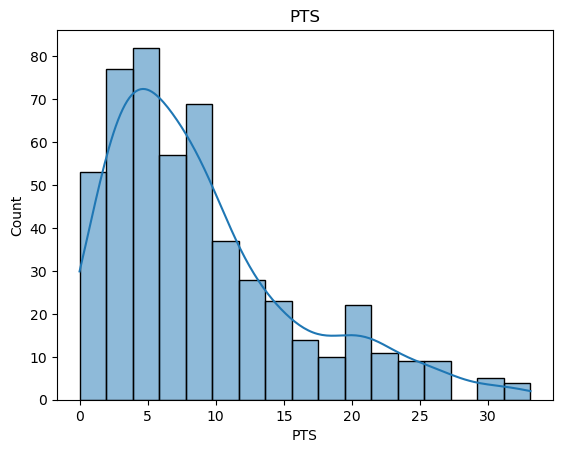

In [14]:
columns = ['Age','G','GS','FG','3P','2P','FT','DRB','STL','PTS']
for i in columns:
    sns.histplot(df_train[i], kde=True)
    plt.title(i)
    plt.show()

We now test wheather the different samples or variables come from the same population or not. We will be using z-test to conclude the result.

- $H_0$ =  mean(1) = mean(2) = ... = mean(n)  
- $H_1$ = Not $H_0$
- If p-valu < $\alpha$, then reject $H_0$, where $\alpha = 0.05$

In [15]:
for col in data_train.drop(columns=["Tm","PTS"]):
    z_stat, p_value = ztest(df[col], df["PTS"], value=0, alternative='two-sided')
    print(col," vs Points")
    print('Statistics=%.3f, p=%.3f' % (z_stat, p))
    alpha = 0.05 
    if p > alpha: 
        print('Same distribution (fail to reject H0)') 
    else: 
            print('Different distribution (reject H0)') 
            
    print("####################\n") 

Pos  vs Points
Statistics=-24.752, p=0.295
Same distribution (fail to reject H0)
####################

Age  vs Points
Statistics=53.210, p=0.295
Same distribution (fail to reject H0)
####################

G  vs Points
Statistics=31.281, p=0.295
Same distribution (fail to reject H0)
####################

GS  vs Points
Statistics=8.395, p=0.295
Same distribution (fail to reject H0)
####################

MP  vs Points
Statistics=22.202, p=0.295
Same distribution (fail to reject H0)
####################

FG  vs Points
Statistics=-19.341, p=0.295
Same distribution (fail to reject H0)
####################

FGA  vs Points
Statistics=-5.730, p=0.295
Same distribution (fail to reject H0)
####################

FG%  vs Points
Statistics=nan, p=0.295
Same distribution (fail to reject H0)
####################

3P  vs Points
Statistics=-28.472, p=0.295
Same distribution (fail to reject H0)
####################

3PA  vs Points
Statistics=-21.023, p=0.295
Same distribution (fail to reject H0)
########

Before performing the Analysis of variance test let us first check if the data as a whole is normal or not. We will use multivariate Analysis

- $H_0$ = The Data has a normal distribution  
- $H_1$ = Not $H_0$

In [16]:
from pingouin import multivariate_normality

test_multi = multivariate_normality(data_train.drop(columns=["Tm","Pos"]))
if test_multi[1]<0.05:
    print("Reject H0 i.e. the data does not follow a normal distribution")
else:
    print("Failed to reject H0 i.e. the data does have a normal distribution")

Reject H0 i.e. the data does not follow a normal distribution


So now when we know that the Data as a whole does not follow a Normal Distribution but as the mean of the data does follow a normal distribution using Central Limit Theorum, so for analysis of variance, we will employ F-test i.e. Tukey's or Bonferroni 

<br>

<H3>4.2.1 Analysis of Variance (Anova): using F-test</H3>

<br>

<H4> One Way ANOVA</H4>

<p>First lets perform a one way anova test on all the columns to check if the Standard deviation of means are same or not.</p>

- $H_0 = \alpha_1 = \alpha_2 = \alpha_3 = ..... = \alpha_n$
- $H_1 =$ Not $H_0$

In [17]:
data_train.columns

Index(['Pos', 'Tm', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [20]:
from scipy.stats import f_oneway

#data_train['Pos'] = data_train['Pos'].apply(lambda x: dict(map(reversed, mapping_dict_1.items())).get(x))
data_columns = data_train.drop(columns=["Tm","Pos","PTS"]).columns
for col in data_columns:
    table = pd.pivot_table(data_train, values= col, index=['Pos'], columns=[], aggfunc=list)
    print(table)
    C = table.loc['C', col]
    PF = table.loc['PF', col]
    PG = table.loc['PG', col]
    SF = table.loc['SF', col]
    SG = table.loc['SG', col]
    stats,p_vaue = f_oneway(C,PF,PG,SF,SG)
    print("{} vs {} \n ".format(col,"Position"))
    if p_vaue > 0.05:
          print("Have the same statistics, i.e. fail to reject H0")
    else:
        print("Reject H0")

                                                   Age
Pos                                                   
C    [36.0, 29.0, 20.0, 29.0, 29.0, 25.0, 30.0, 33....
PF   [27.0, 25.0, 21.0, 26.0, 30.0, 27.0, 33.0, 23....
PG   [26.0, 28.0, 26.0, 22.0, 23.0, 21.0, 28.0, 25....
SF   [19.0, 23.0, 39.0, 27.0, 25.0, 20.0, 25.0, 25....
SG   [23.0, 22.0, 24.0, 31.0, 23.0, 25.0, 23.0, 23....
Age vs Position 
 
Reject H0
                                                     G
Pos                                                   
C    [48.0, 14.0, 55.0, 48.0, 37.0, 57.0, 46.0, 27....
PF   [50.0, 28.0, 31.0, 4.0, 42.0, 49.0, 58.0, 57.0...
PG   [51.0, 51.0, 42.0, 30.0, 1.0, 12.0, 30.0, 2.0,...
SF   [57.0, 55.0, 3.0, 37.0, 46.0, 62.0, 27.0, 3.0,...
SG   [27.0, 8.666666666666666, 48.0, 49.0, 1.0, 41....
G vs Position 
 
Have the same statistics, i.e. fail to reject H0
                                                    GS
Pos                                                   
C    [48.0, 1.0, 52.0, 0.

We can see that the overall p-value from the ANOVA table is not significant ie. less than .05, so we have sufficient evidence to say that the mean values across each group are not equal.

However, this doesn’t tell us which groups are different from each other. It simply tells us that not all of the group means are equal. In order to find out exactly which groups are different from each other, we must conduct a post hoc test. Thus, we will perform Bonferroni test.



<H4> 4.2.2 Performing the tukeys method </H4>
<br>

$H_0$ = $mean(1)==mean(2)$ , $mean(1)==mean(3)$ , $mean(n)==mean(m)$  
$H_1$ = Not $H_0$

In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(data_columns.tolist())
for col in data_columns:
    tukey_results = pairwise_tukeyhsd(df_train[col], df_train['Pos'])
    print("{} vs {} \n ".format(col,"Position"),tukey_results )

['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']
Age vs Position 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -1.5683 0.0584 -3.1705 0.0339  False
     0      2    -0.82  0.688 -2.5397 0.8996  False
     0      3  -0.3331 0.9836 -2.0348 1.3687  False
     0      4  -1.3094 0.2284  -3.029 0.4103  False
     1      2   0.7483 0.7115 -0.8683 2.3649  False
     1      3   1.2353 0.2144 -0.3623 2.8328  False
     1      4   0.2589 0.9923 -1.3577 1.8755  False
     2      3    0.487 0.9371 -1.2284 2.2023  False
     2      4  -0.4894 0.9383 -2.2225 1.2437  False
     3      4  -0.9763  0.525 -2.6917  0.739  False
---------------------------------------------------
G vs Position 
   Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 

2P vs Position 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.8843 0.0095  -1.621 -0.1476   True
     0      2  -0.4462 0.5337 -1.2369  0.3445  False
     0      3  -0.4847 0.4374 -1.2672  0.2978  False
     0      4  -0.8602 0.0252 -1.6509 -0.0695   True
     1      2   0.4381 0.4893 -0.3052  1.1815  False
     1      3   0.3996 0.5699  -0.335  1.1342  False
     1      4   0.0241    1.0 -0.7192  0.7675  False
     2      3  -0.0385 0.9999 -0.8273  0.7502  False
     2      4   -0.414 0.6136 -1.2109  0.3829  False
     3      4  -0.3755 0.6893 -1.1642  0.4133  False
----------------------------------------------------
2PA vs Position 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.7818 0.4915  -2.111 0.5474  False
     0      2

STL vs Position 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.1723 0.0094   0.029  0.3156   True
     0      2    0.095 0.4402 -0.0588  0.2488  False
     0      3   0.3499    0.0  0.1978  0.5021   True
     0      4   0.1551 0.0469  0.0013  0.3089   True
     1      2  -0.0773 0.5866 -0.2219  0.0673  False
     1      3   0.1776 0.0064  0.0348  0.3205   True
     1      4  -0.0172 0.9976 -0.1618  0.1274  False
     2      3   0.2549 0.0001  0.1015  0.4083   True
     2      4   0.0601 0.8261 -0.0949  0.2151  False
     3      4  -0.1948  0.005 -0.3482 -0.0414   True
----------------------------------------------------
BLK vs Position 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.5407    0.0 -0.6663 -0.4152   True
     0  

So after Tukeys analysis it is quite clear that the different positions does not have the same mean across all the stats parameter so the Variance of the data set is not uniform.

We will now plot the graph for the position vs 2 points made and see what does the mean distribution look like

<AxesSubplot:xlabel='Pos', ylabel='2P'>

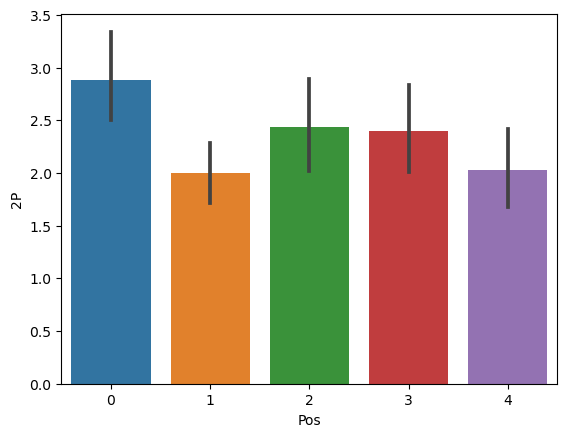

In [35]:
data_t = df_train
#data_t['Pos'] = data_t['Pos'].apply(lambda x: dict(map(reversed, mapping_dict_1.items())).get(x))
sns.barplot(x=data_t["Pos"], y=data_t["2P"])

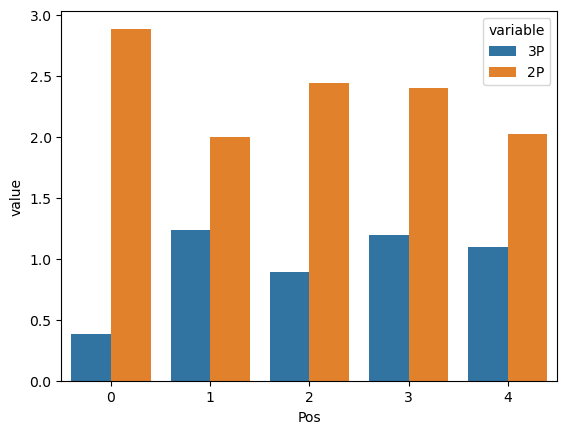

In [36]:
grouped_df = data_t.groupby(["Pos"]).agg({'3P': 'mean', '2P': 'mean'}).reset_index()

# Plot the graph using seaborn
sns.barplot(x='Pos', y='value', hue='variable', data=pd.melt(grouped_df, id_vars=["Pos"], var_name='variable', value_name='value'))

# Show the plot
plt.show()


<AxesSubplot:xlabel='Pos', ylabel='3P'>

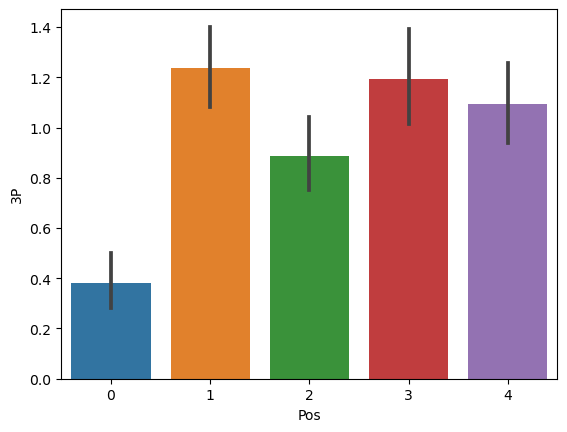

In [37]:
sns.barplot(x=data_t["Pos"], y=data_t["3P"])

<H3> 4.3 Analysis of Categorical Variables</H3>

<br>
<H4>4.3.1 Chi square Test of Independence </H4> 

We will be using the Chi-Square Test for checking if the Categorical columns have what kind of distribution and homogeneity. We are performing the test between The Position and the Age where age is divided into 4 levels.

<OL>
    <li> Level 1: 0-20 (years old)</li>
    <li> Level 2: 20-25 (years old)</li>
    <li> Level 3: 25-30 (years old)</li>
    <li> Level 4: 30+ (Years old)</li>
</OL>  

- $ H_0= $Categorical Variables are independent
- $H_1 =$ Not $H_0$

In [39]:
df_cat = df_train.copy()
age_bins = [0, 20, 25, 30, float('inf')]
age_labels = ['Level 1', 'Level 2', 'Level 3', 'Level 4']
df_cat['AgeCategory'] = pd.cut(df_cat['Age'], bins=age_bins, labels=age_labels)

In [40]:
counts = df_cat.groupby(['Pos', 'AgeCategory']).size()
counts = counts.unstack()
print(counts)

AgeCategory  Level 1  Level 2  Level 3  Level 4
Pos                                            
0                  3       45       31       18
1                 17       58       38       14
2                 10       42       27       15
3                  5       47       25       21
4                  9       45       29       11


In [41]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(counts)
if p < 0.05:
    print("Reject - H0: (null hypothesis) The two variables are independent as pvalue={}.".format(p))
else:
    print("Failed to Reject H0 as pvalue = {}".format(p))

Failed to Reject H0 as pvalue = 0.23874799468950164


So After performing Chi square test is it clear that the 4 groups are linearly indepenent and have no effect on one another. 

<H5>Perdorm Chi Square test  </H5> 

In [44]:
Pts_bin = [0, 10, 15, 25, 30,float('inf')]
age_labels = ['Level 1', 'Level 2', 'Level 3', 'Level 4']
df_cat['PointCategory'] = pd.cut(df_cat['PTS'], bins=age_bins, labels=age_labels)


In [45]:
counts = df_cat.groupby(['Pos', 'PointCategory']).size()
counts = counts.unstack()
print(counts)

PointCategory  Level 1  Level 2  Level 3  Level 4
Pos                                              
0                   90        3        2        1
1                  108       13        2        0
2                   83        4        4        2
3                   84        5        5        3
4                   86        4        3        0


In [46]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(counts)
if p < 0.05:
    print("Reject - H0: (null hypothesis) The two variables are independent as pvalue={}.".format(p))
else:
    print("Failed to Reject H0 as pvalue = {}".format(p))

Failed to Reject H0 as pvalue = 0.17724402128876635


<H3> 4.4 Linear Regression </H3>  

Let us First perform normal Linear regression using the Sklearn library

In [50]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [54]:
data_scaled_2 = scaling_data(df_train)# Performed scaling of data. 
X = data_scaled_2.drop(columns=["PTS","Tm"])
Y = data_scaled_2["PTS"]
print(len(X.columns))
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=1)
clf = LinearRegression().fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("MSE =", mse(y_pred, y_test))
print("MAE =", mae(y_pred, y_test))
print("R2 score = "+str(r2_score(y_pred,y_test)))

26
MSE = 4.418894872536845e-06
MAE = 0.0016303930670629498
R2 score = 0.9998727674057615


In [55]:
Y

0      0.141994
1      0.073515
2      0.277946
3      0.516616
4      0.123867
         ...   
505    0.308157
506    0.731118
507    0.154079
508    0.175227
509    0.785498
Name: PTS, Length: 510, dtype: float64

It is clearly visible that right now my model using linear regression is having a very good prediction of Points column.The $R^2$ value is 0.998 which is very close to the perfect score of 1.

<br>

Performing Cross validation on the same data set with CV=4  

<h3> 4.5.1 Cross Validation </h3>

In [56]:
lg_resultant = cross_validate(LinearRegression(n_jobs=-1), 
                              x_train, 
                              y_train, 
                              cv=5,
                            return_train_score=True)

print("Mean Training Score = ", lg_resultant['train_score'].mean())
print("Mean Testing Score = ", lg_resultant['test_score'].mean())

Mean Training Score =  0.9999172561536283
Mean Testing Score =  0.999890007867189


We find that the $R^2$ score has improved by 0.00002, thus Cross validation is a effective method of Resampling for our dataset. 

We are not performing Bootstrapping as out data sset had good number of data and bootstrapping will not have a major effect in comparision to cross-Validation

<h3> 4.6 Linear Model Selection and Regularization</h3>

<h4> 4.6.1 Find the k best parameters using Fisher Score</h4>

In [57]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import SelectKBest, f_classif
aic_score = []
mae_score = []
mse_score = []
columns = X.columns.tolist()
for i in range(1,len(columns)+1):
    select_clf = SelectKBest(score_func=f_classif, k=i)
    select_clf.fit(X,Y)
    new_X = X.iloc[:,select_clf.get_support(indices=True)]
    #print(new_X)
    x_train, x_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.2, random_state=1)
    #print(x_train,y_train)
    log_reg = sm.OLS(y_train, x_train).fit()
    
    clf = LinearRegression().fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    print("Number of Paramters : {}".format(i))
    print("Paramters name : {}".format(columns[:i]))
    print("AIC Score: {}".format(log_reg.aic))
    print("MSE =", mse(y_pred, y_test))
    print("MAE =", mae(y_pred, y_test))
    aic_score.append(log_reg.aic)
    mse_score.append(mse(y_pred, y_test))
    mae_score.append(mae(y_pred, y_test))
    print("****************************************")
    print("")

Number of Paramters : 1
Paramters name : ['Pos']
AIC Score: -1748.808246569091
MSE = 0.0006223090999644811
MAE = 0.016689245580122677
****************************************

Number of Paramters : 2
Paramters name : ['Pos', 'Age']
AIC Score: -1822.6472209671442
MSE = 0.0004746803296988954
MAE = 0.015243017615743502
****************************************

Number of Paramters : 3
Paramters name : ['Pos', 'Age', 'G']
AIC Score: -1838.6331516630853
MSE = 0.0003886834861331294
MAE = 0.013672557684780071
****************************************

Number of Paramters : 4
Paramters name : ['Pos', 'Age', 'G', 'GS']
AIC Score: -3166.3704324602495
MSE = 1.8087784658286606e-05
MAE = 0.0032316764091547224
****************************************

Number of Paramters : 5
Paramters name : ['Pos', 'Age', 'G', 'GS', 'MP']
AIC Score: -3632.379725077759
MSE = 7.498911204606277e-06
MAE = 0.0021498075635327705
****************************************

Number of Paramters : 6
Paramters name : ['Pos', 'Age

It is clear that with number of parameters as 13 and the parameters being 'Pos', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA'. We can get a good AIC score along with MSE so these 13 parameters are the best estimation to number of points scored using kbest feature selection. Let us train a Linear regression model using these 13 columns and check the $R^2$ score.

In [58]:
X = data_scaled_2[['Pos', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA']]
Y = data_scaled_2["PTS"]
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=1)
clf = LinearRegression().fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("MSE =", mse(y_pred, y_test))
print("MAE =", mae(y_pred, y_test))
print("R2 score = "+str(r2_score(y_pred,y_test)))

MSE = 0.00035998616649136547
MAE = 0.013420575501455164
R2 score = 0.9902498685673672


It is clear that with Fisher selection method even with 13 features we were able to predict the Point of test data with an $R^2$ score of 0.9902. This helps us work with less number of parameter and get the same result. 

In [59]:
k =list(range(1, 27))

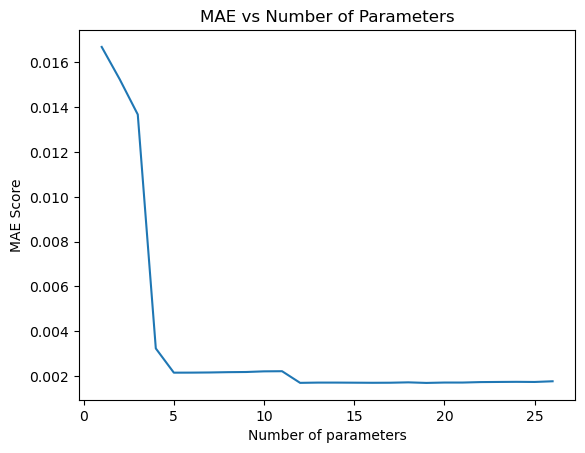

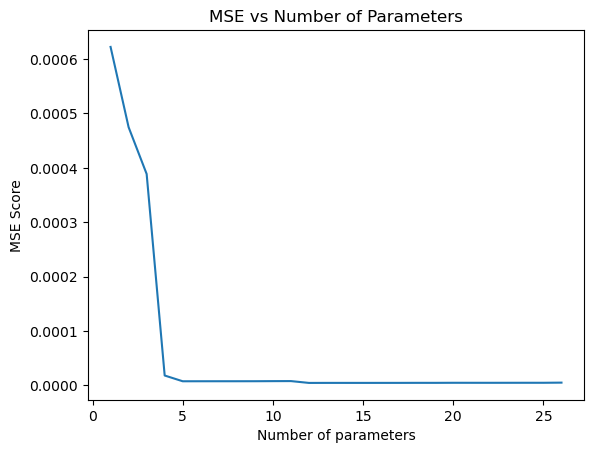

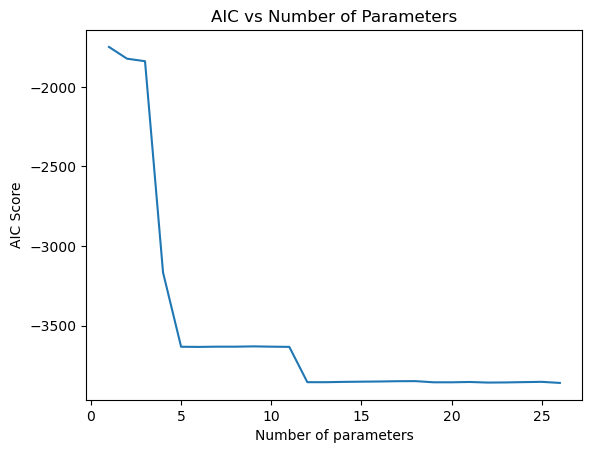

In [60]:
plt.plot(k,mae_score)
plt.xlabel("Number of parameters")
plt.ylabel("MAE Score")
plt.title("MAE vs Number of Parameters")
plt.show()

plt.plot(k,mse_score)
plt.xlabel("Number of parameters")
plt.ylabel("MSE Score")
plt.title("MSE vs Number of Parameters")

plt.show()

plt.plot(k,aic_score)
plt.xlabel("Number of parameters")
plt.ylabel("AIC Score")
plt.title("AIC vs Number of Parameters")

plt.show()

<h4> 4.6.2 Forward Selection and Backward Selection to find the best parameter </h4> 

**Forward Selection**

In [61]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
linReg = LinearRegression()
X = data_scaled_2.drop(columns=["PTS","Tm"])
Y = data_scaled_2["PTS"]
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=1)
sfs1 = SFS(linReg, 
           k_features=26, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=5)

sfs1 = sfs1.fit(np.array(x_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.5s finished

[2023-05-05 21:57:03] Features: 1/26 -- score: 0.9818708455910021[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished

[2023-05-05 21:57:03] Features: 2/26 -- score: 0.9909083388624007[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.5s finished

[2023-05-05 21:57:04] Features: 3/26 -- score: 0.9998906771206357[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [62]:
res = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

res["feature_names"] = res["feature_idx"].apply(lambda x: [X.columns.tolist()[i] for i in x])
res.iloc[8:14,3:4].values

array([[list(['G', 'FG', '3P', '3PA', '2P', 'eFG%', 'FT', 'FTA', 'FT%'])],
       [list(['G', 'FG', 'FG%', '3P', '3PA', '2P', 'eFG%', 'FT', 'FTA', 'FT%'])],
       [list(['G', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FTA', 'FT%'])],
       [list(['G', 'MP', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FTA', 'FT%'])],
       [list(['G', 'GS', 'MP', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FTA', 'FT%'])],
       [list(['G', 'GS', 'MP', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FTA', 'FT%', 'PF'])]],
      dtype=object)

From out Analysis it is clear that using forward selection these columns are the most important columns/attributes for us to consider   
- 'G', 'FG', '3P', '3PA', '2P', 'eFG%', 'FT', 'FTA', 'FT%'.   

as the $R^2$ score achieved is 0.9999 which is the highest score we can achieve using the least number of parameters.  

**Backward Selection**

In [63]:
sfs1 = SFS(linReg, 
           k_features=6, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=5)

sfs1 = sfs1.fit(np.array(x_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.5s finished

[2023-05-05 21:57:16] Features: 25/6 -- score: 0.9998914133825971[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.3s finished

[2023-05-05 21:57:17] Features: 24/6 -- score: 0.9998927915389586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.4s finished

[2023-05-05 21:57:19] Features: 23/6 -- score: 0.9998940195847219[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [64]:
res = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
res["feature_names"] = res["feature_idx"].apply(lambda x: [X.columns.tolist()[i] for i in x])
res.iloc[11:19,3:4].values

array([[list(['G', 'GS', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FT%', 'DRB', 'TRB', 'STL', 'PF'])],
       [list(['G', 'GS', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FT%', 'DRB', 'TRB', 'PF'])],
       [list(['G', 'GS', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FT%', 'DRB', 'TRB'])],
       [list(['G', 'GS', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FT%', 'TRB'])],
       [list(['G', 'GS', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FT%'])],
       [list(['G', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FT%'])],
       [list(['G', 'FG', 'FG%', '3P', '3PA', '2P', 'eFG%', 'FT', 'FT%'])],
       [list(['G', 'FG', '3P', '3PA', '2P', 'eFG%', 'FT', 'FT%'])]],
      dtype=object)

From Back ward selection also it is clearly visibile that  

- G', 'GS', 'FG', 'FG%', '3P', '3PA', '3P%', '2P', 'eFG%', 'FT', 'FT%', 'DRB', 'TRB'

This columns can give us an $R^2$ score of 0.9999 and with the least number of features

<h3> 4.6.3 Ridge and Lasso Regression to predict the best Parameters and calculate the $R^2$ Score</h3>  

**Ridge Regression**

In [65]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 10, num=100)
ridge_cv = RidgeCV(alphas=alphas, normalize=True)
ridge_cv.fit(x_train, y_train)
alpha = ridge_cv.alpha_
print(f'Optimal alpha: {alpha}')

# Fit Ridge regression model with optimal alpha
ridge = Ridge(alpha=alpha, normalize=True)
ridge.fit(x_train, y_train)

# Evaluate performance on test set
y_pred = ridge.predict(x_test)
mse = r2_score(y_test, y_pred)
print('r2:', mse)


Optimal alpha: 1.1233240329780266e-05
r2: 0.9998722716260305


With the Optimal Alpha found at $1.12e^{-05}$, when we train the model we get a $R^2$ score of 0.9998 which is less then what we got using Forward and backward selection.  

**Lasso Regression**

In [66]:
from sklearn.linear_model import LassoCV


# Perform Lasso regression with cross-validation
model = LassoCV(cv=5)
model.fit(x_train, y_train)

# Print the selected alpha value
print('Selected alpha value:', model.alpha_)

# Compute the root mean squared error on the training set
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print('r2:', r2)

Selected alpha value: 5.688778929469479e-05
r2: 0.9998879553938856


<h3> 4.6.4 PCA</h3>   

Principal component analysis, or PCA, is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset. The features are selected on the basis of variance that they cause in the output. The feature that causes highest variance is the first principal component. The feature that is responsible for second highest variance is considered the second principal component, and so on. It is important to mention that principal components do not have any correlation with each other

Text(0.5, 1.0, 'PCA')

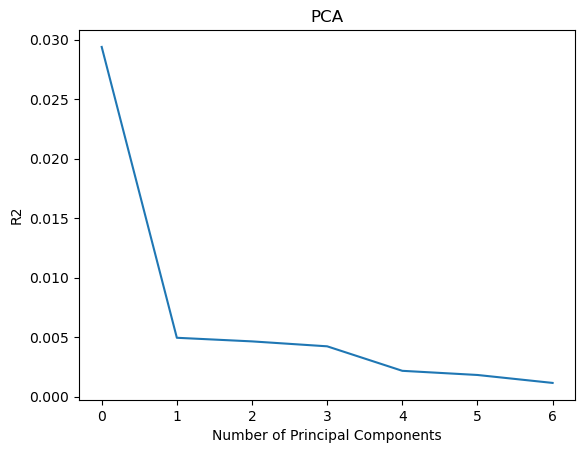

In [67]:
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn import model_selection



#scale predictor variables
pca = PCA(0.95)
X_reduced = pca.fit_transform(x_train)

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr  = Ridge()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y_train, cv=cv,
           scoring='r2').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 7):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('R2')
plt.title('PCA')

In [68]:
variance = pca.explained_variance_ratio_
variance

array([0.51214189, 0.13625955, 0.06440247, 0.05755622, 0.03998244,
       0.0309248 , 0.0295512 , 0.02414899, 0.02099596, 0.01838165,
       0.01559419, 0.01266215])

PCA Analysis clearly shows that within 7-8 components all the variance in our data can be accomodated thus the data has many linearly dependent columns.

<h3> 4.7 Moving Beyond Linearity </h3>

Polynomial regression with degree 2-5 are done a there respective $R^2$ are plotted. 

In [69]:
from sklearn.preprocessing import PolynomialFeatures
r2_score_list=[]
for i in range(2,6):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(x_train)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y_train)
    X_test_poly = poly.transform(x_test)
    y_pred = poly_reg.predict(X_test_poly)
    r2_score_list.append(r2_score(y_test, y_pred))



Text(0.5, 1.0, 'number of degree vs r2 score')

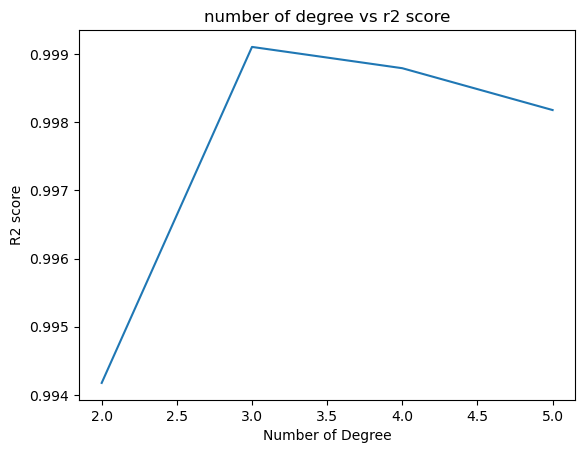

In [70]:
poly= [i for i in range(2,6)]
plt.plot(poly,r2_score_list)
plt.xlabel('Number of Degree')
plt.ylabel('R2 score')
plt.title('number of degree vs r2 score')

<H3> Conclusion </H3>

So We can conclude that For my data set the best method predicting the point of a player is by using a Polynomial function of degree 3 with 10 of the below mentioned columns which give me an $R^2$ score of 0.99998 

<h3> References</h3>  

- https://sit.instructure.com/courses/64211/files/11416378?module_item_id=1804363
- https://sit.instructure.com/courses/64211/files/11055855?module_item_id=1763023
- ChatGPT
- https://sit.instructure.com/courses/64211/files/11055859?module_item_id=1763026